In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = [10, 5]



# Import the data

In [2]:
df_train = pd.read_csv('train_auto.csv', index_col='INDEX')
df_test = pd.read_csv('test_auto.csv', index_col='INDEX')

# Data Analysis

In [3]:
df_train.describe()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,1.000000,107586.136200,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


In [4]:
df_test.describe()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,0.0,0.0,2141.000000,2140.000000,2141.000000,2047.000000,2141.000000,2141.000000,2141.000000,2141.000000,2012.000000
mean,NaN,NaN,0.162541,45.016822,0.717422,10.379091,33.152265,5.244745,0.808968,1.765997,8.183400
std,NaN,NaN,0.486949,8.525006,1.116579,4.170008,15.722393,3.971026,1.137481,2.203413,5.766263
min,NaN,NaN,0.000000,17.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,NaN,NaN,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,NaN,NaN,0.000000,51.000000,1.000000,13.000000,43.000000,7.000000,2.000000,3.000000,12.000000
max,NaN,NaN,3.000000,73.000000,5.000000,19.000000,105.000000,25.000000,5.000000,12.000000,26.000000


The description of the continuous variables does not highlight any anomalies, other than a minimal value of -3 for the car age. We can easily change this value, and other negative ones, to 0 for example, to get it back to normal.

In [5]:
df_train.CAR_AGE = df_train.CAR_AGE.apply(lambda x: 0 if x < 0 else x)
df_test.CAR_AGE = df_test.CAR_AGE.apply(lambda x: 0 if x < 0 else x)


In [6]:
print(f"There are {df_train.TARGET_FLAG.sum()} positive records and {(1-df_train.TARGET_FLAG).sum()} negative ones")
print(f"That represents {df_train.TARGET_FLAG.sum() / len(df_train)* 100:.2f}% positive classes")

There are 2153 positive records and 6008 negative ones
That represents 26.38% positive classes


We are dealing with a classification problem. Given that our data seems to be imbalancedbalanced, it is best to use the F1 score instead of the accuracy as evaluation metrics.

## Preprocess the columns

In [7]:
# Create new df to keep the processed columns
X_train = pd.DataFrame(index=df_train.index)
X_test = pd.DataFrame(index=df_test.index)

y_train = df_train["TARGET_FLAG"]
y_test = pd.DataFrame(index=df_test.index)


First we process the columns with string values that correspond to currency

In [8]:
def money_str_to_int(df):
    df = df.str.replace(",", "")
    df = df.str.replace("$", "")
    df = df.astype("float")
    df = df.fillna(df.mean())
    return(df)

X_train["home_val"] = money_str_to_int(df_train.HOME_VAL)
X_train["income"] = money_str_to_int(df_train.INCOME)
X_train["oldclaim"] = money_str_to_int(df_train.OLDCLAIM)
X_train["bluebook"] = money_str_to_int(df_train.BLUEBOOK)

X_test["home_val"] = money_str_to_int(df_test.HOME_VAL)
X_test["income"] = money_str_to_int(df_test.INCOME)
X_test["oldclaim"] = money_str_to_int(df_test.OLDCLAIM)
X_test["bluebook"] = money_str_to_int(df_test.BLUEBOOK)

    

/Users/Claudia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


Then we treat the categorical variables

In [9]:
X_train["car_use_is_commercial"] = df_train.CAR_USE == 'Commercial'
X_train["is_red_car"] = df_train.RED_CAR == 'yes'
X_train["is_revoked"] = df_train.REVOKED == 'Yes'
X_train["is_parent1"] = df_train.PARENT1 == 'Yes'
X_train["is_urban"] = df_train.URBANICITY == 'Highly Urban/ Urban'
X_train["is_male"] = df_train.SEX == 'M'
X_train["is_married"] = df_train.MSTATUS == 'Yes'

X_test["car_use_is_commercial"] = df_test.CAR_USE == 'Commercial'
X_test["is_red_car"] = df_test.RED_CAR == 'yes'
X_test["is_revoked"] = df_test.REVOKED == 'Yes'
X_test["is_parent1"] = df_test.PARENT1 == 'Yes'
X_test["is_urban"] = df_test.URBANICITY == 'Highly Urban/ Urban'
X_test["is_male"] = df_test.SEX == 'M'
X_test["is_married"] = df_test.MSTATUS == 'Yes'


We can apply a hierarchical encoding to the EDUCATION column

In [10]:
dict_EDUCATION = {
    "<High School": 0,
    "z_High School": 1,
    "Bachelors": 2,
    "Masters": 3,
    "PhD":4
}

X_train["education"] = df_train.EDUCATION.map(dict_EDUCATION)
X_test["education"] = df_test.EDUCATION.map(dict_EDUCATION)


And a one hot encoding to the columsn with several categories

In [11]:
def one_hot_columns(df_to_encode, df):
    df_to_encode = df_to_encode.fillna('None')
    col_one_hot = pd.get_dummies(df_to_encode)
    df = pd.concat([df, col_one_hot], axis=1)
    return df

In [12]:
X_train = one_hot_columns(df_train["JOB"], X_train)
X_train = one_hot_columns(df_train["CAR_TYPE"], X_train)

X_test = one_hot_columns(df_test["JOB"], X_test)
X_test = one_hot_columns(df_test["CAR_TYPE"], X_test)


Finally, we add the columns that do not need this kind of preprocessing

In [13]:
X_train[["kidsdriv", "age", "homekids", "yoj", "travtime", "tif", "clm_freq", "mvr_pts", "car_age"]] =  df_train[["KIDSDRIV", "AGE", "HOMEKIDS", "YOJ", "TRAVTIME", "TIF", "CLM_FREQ", "MVR_PTS", "CAR_AGE"]]
X_test[["kidsdriv", "age", "homekids", "yoj", "travtime", "tif", "clm_freq", "mvr_pts", "car_age"]] =  df_test[["KIDSDRIV", "AGE", "HOMEKIDS", "YOJ", "TRAVTIME", "TIF", "CLM_FREQ", "MVR_PTS", "CAR_AGE"]]


In [14]:
X_train["age"] = X_train["age"].fillna(int(X_train["age"].mean()))
X_test["age"] = X_test["age"].fillna(int(X_test["age"].mean()))

X_train["yoj"] = X_train["yoj"].fillna(int(X_train["yoj"].mean()))
X_test["yoj"] = X_test["yoj"].fillna(int(X_test["yoj"].mean()))

X_train["car_age"] = X_train["car_age"].fillna(int(X_train["car_age"].mean()))
X_test["car_age"] = X_test["car_age"].fillna(int(X_test["car_age"].mean()))


In [15]:
X_train.head()

,home_val,income,oldclaim,bluebook,car_use_is_commercial,is_red_car,is_revoked,is_parent1,is_urban,is_male,...,z_SUV,kidsdriv,age,homekids,yoj,travtime,tif,clm_freq,mvr_pts,car_age
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0.0,67349.000000,4461.0,14230.0,False,True,False,False,True,True,...,0,0,60.0,0,11.0,14,11,2,3,18.0
2,257252.0,91449.000000,0.0,14940.0,True,True,False,False,True,True,...,0,0,43.0,0,11.0,22,1,0,0,1.0
4,124191.0,16039.000000,38690.0,4010.0,False,False,False,False,True,False,...,1,0,35.0,1,10.0,5,4,2,3,10.0
5,306251.0,61898.094609,0.0,15440.0,False,True,False,False,True,True,...,0,0,51.0,0,14.0,32,7,0,0,6.0
6,243925.0,114986.000000,19217.0,18000.0,False,False,True,False,True,False,...,1,0,50.0,0,10.0,36,1,2,3,17.0


Last step, extract a validation set from the training set

In [16]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [17]:
print(f"The positive class represents {y_tr.sum() / len(X_tr)* 100:.2f}% of the training set")
print(f"The positive class represents {y_val.sum() / len(X_val)* 100:.2f}% of the validation set")

The positive class represents 26.38% of the training set
The positive class represents 26.39% of the validation set


# Models

This is a classification problem, so we can start by using a SVM.

In [18]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', C=100, kernel='linear'))
clf.fit(X_tr, y_tr)

In [22]:
y_tr_pred = clf.predict(X_tr)
y_val_pred = clf.predict(X_val)
clf.score(X_tr, y_tr)

0.7879901960784313

In [23]:
clf.score(X_val, y_val)

0.7985303123086344

In [24]:
print(15*"*" + "Training Scores" + 15*"*")
print("Recall: {}".format(recall_score(y_tr, y_tr_pred)))
print("Precision: {}".format(precision_score(y_tr, y_tr_pred)))
print("F1: {}".format(f1_score(y_tr, y_tr_pred)))

print(15*"*" + "Training Scores" + 15*"*")
print("Recall: {}".format(recall_score(y_val, y_val_pred)))
print("Precision: {}".format(precision_score(y_val, y_val_pred)))
print("F1: {}".format(f1_score(y_val, y_val_pred)))

***************Training Scores***************
Recall: 0.3641114982578397
Precision: 0.6844978165938864
F1: 0.4753601213040182
***************Training Scores***************
Recall: 0.382830626450116
Precision: 0.7236842105263158
F1: 0.5007587253414264


We can continue by using a Random Forest classifier

In [36]:
RF = RandomForestClassifier(criterion="gini", random_state=42)
p_grid_RF = {'max_depth': [5, 25, 50],
             'n_estimators': [5, 25, 50, 100],
             'min_samples_leaf': [2, 5, 10],
             'max_features': ['sqrt','log2', 'auto']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=10)
grid_RF.fit(X_tr, y_tr)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 25, 50],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [5, 25, 50, 100]},
             scoring='accuracy')

In [37]:
print("Best params: {}".format(grid_RF.best_params_))

Best params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}


In [39]:
best_RF = RandomForestClassifier(criterion="gini", random_state=42,
                                 max_depth= 50,
                                 max_features="sqrt",
                                 min_samples_leaf=2,
                                 n_estimators=100)
best_RF.fit(X_tr, y_tr)

y_tr_pred = best_RF.predict(X_tr)
y_val_pred = best_RF.predict(X_val)

print(15*"*" + "Training Scores" + 15*"*")
print("Recall: {}".format(recall_score(y_tr, y_tr_pred)))
print("Precision: {}".format(precision_score(y_tr, y_tr_pred)))
print("F1: {}".format(f1_score(y_tr, y_tr_pred)))


print(15*"*" + "Validation Scores" + 15*"*")
print("Recall: {}".format(recall_score(y_val, y_val_pred)))
print("Precision: {}".format(precision_score(y_val, y_val_pred)))
print("F1: {}".format(f1_score(y_val, y_val_pred)))

***************Training Scores***************
Recall: 0.9123112659698026
Precision: 1.0
F1: 0.9541451563923475
***************Validation Scores***************
Recall: 0.4060324825986079
Precision: 0.7172131147540983
F1: 0.5185185185185185


These scores show that while the training set has good precision and recall, there is an overfitting problem on the validation set, with low scores overall compared to the training. The main problem comes from the recall, meaning that our model is mediocre on recognizing the positive classes on our validation set.

Feature ranking:
1. feature 1 representing income (0.082431)
2. feature 3 representing bluebook (0.080632)
3. feature 31 representing travtime (0.074805)
4. feature 2 representing oldclaim (0.071171)
5. feature 28 representing age (0.070542)
6. feature 0 representing home_val (0.067415)
7. feature 34 representing mvr_pts (0.054698)
8. feature 8 representing is_urban (0.053317)
9. feature 35 representing car_age (0.051348)
10. feature 30 representing yoj (0.045907)
11. feature 32 representing tif (0.044292)
12. feature 33 representing clm_freq (0.037636)
13. feature 11 representing education (0.032005)
14. feature 29 representing homekids (0.023038)
15. feature 4 representing car_use_is_commercial (0.020343)
16. feature 6 representing is_revoked (0.019844)
17. feature 27 representing kidsdriv (0.015829)
18. feature 21 representing Minivan (0.015526)
19. feature 10 representing is_married (0.015112)
20. feature 7 representing is_parent1 (0.014070)
21. feature 16 representing Manager (0.0

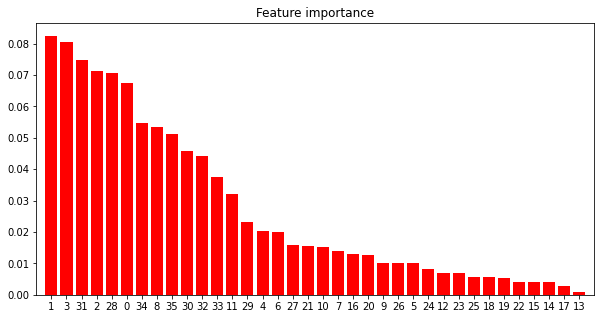

In [31]:
importances = best_RF.feature_importances_
indices = np.argsort(importances)[::-1]
labels = X_tr.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(36):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(36), importances[indices[0:36]], color="r", align="center")
plt.xticks(range(36), indices[0:36])
plt.xlim([-1, 36])
plt.show()

# Generate a CSV file with the predictions

Let's save the predictions obtained with the random forests.

In [40]:
path = "Y_test.csv"
y_te_pred = best_RF.predict(X_test).tolist()
y_test["TARGET_FLAG"] = y_te_pred

print("saving predictions to " + path)
y_test.to_csv(path, index=True, index_label="INDEX")
print("saved predictions")

saving predictions to Y_test.csv
saved predictions
